<a href="https://colab.research.google.com/github/kapibara3chi/NLPTesForGC/blob/main/NLPTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip

In [2]:
!pip  install -U ginza ja_ginza_electra
!pip install plantuml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 8.5 MB/s 
     |████████████████████████████████| 2.2 MB 60.1 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 283 kB 61.3 MB/s 
     |████████████████████████████████| 1.1 MB 54.8 MB/s 
     |████████████████████████████████| 4.7 MB 38.1 MB/s 
     |████████████████████████████████| 7.6 MB 70.2 MB/s 
     |████████████████████████████████| 6.6 MB 48.5 MB/s 
     |████████████████████████████████| 182 kB 60.5 MB/s 
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574782 sha256=91744b0620bda804637190e476d1a6127ba81f9fc474412732a4924380c87346
  Stored in directory: /root/.cache/pip/wheels/ca/e3/ed/e78fecf6fd34349114d292242a16fc08d513fb32c2d9c5d786
  Created wheel for sudachitra: filename=SudachiTra-0.1.7-py3-none-any.whl size=266095 sha256=94631

# Plant UML

[{'filename': 'sample.puml', 'gen_success': True}]


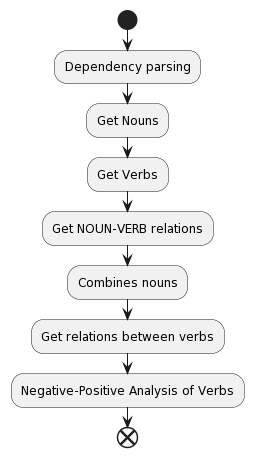

In [4]:
with open('/content/sample.puml', 'w+') as f:
	f.write('''

@startuml
start
:Dependency parsing;
:Get Nouns;
:Get Verbs;
:Get NOUN-VERB relations;
:Combines nouns;
:Get relations between verbs;
:Negative-Positive Analysis of Verbs;
end
@enduml

''')

!python -m plantuml sample.puml

from IPython.display import Image

Image('sample.png')

# Code

In [4]:
import ginza
from spacy import displacy
import spacy
class DependencyAnalysis:
    def __init__(self):
        self.nlp = spacy.load('ja_ginza_electra')
        self.indices = []

    def get_analysis(self, text):
        """係り受け解析"""
        doc = self.nlp(text)

        token_head_list = []

        for sent in doc.sents:
            for token in sent:
                token_head_list.append(
                    {"i": token.i, "orth": token.orth_, "base": token.lemma_,
                     "head": token.head.i, "dep": token.dep_,"pos":token.pos_,
                     "tag":token.tag_})

        displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

        return token_head_list
    # def get(self, text, target):
    #   # 係り受け解析
    #   self.depend_indices = self.get_analysis(text)
    #   print(self.depend_indices)

    def get_words(self,  m, head):
        """対象の領域の抽出"""
        
        if m["head"] == head :
            for n in self.depend_indices:
                self.get_words(m=n, head=m["i"])
                            
            self.indices.append(m["i"])
        
        return
    def get(self, text, target):
        
        # 係り受け解析
        self.depend_indices = self.get_analysis(text)
        # print(self.depend_indices)
        for i in self.depend_indices:
          print(i)
                
        # 係り元のインデックスを取得
        head = self.depend_indices[target]["head"]
        # print(head)

        # 係り元のかかり先を探索
        self.indices.append(head)
        print(self.indices)#list of head?
        for m in self.depend_indices:
            if m["head"] == head and m["dep"] != "ROOT":
                self.get_words(m, head=head)

        clause = ""
        for clause_num in sorted(self.indices):
            clause = clause + str(self.depend_indices[clause_num]["orth"])
            
        return clause

    def dep_analysis_main(self,text):
        # 係り受け解析
        self.depend_indices = self.get_analysis(text)
        # print(self.depend_indices)
        for i in self.depend_indices:
          print(i)

        print("-"*100)
        #get NOUN
        noun_l=self.get_noun()
        for l in noun_l:
          print(l)

        print("-"*100)
        #get VERB
        verb_l=self.get_verb()
        for l in verb_l:
          print(l)

        #get NOUN-VERB relations
        for i in noun_l:
          print("noun:",i)
          verb=self.seek_verb(i)
          print("verb:",verb)


    def get_noun(self):
      # print(type(self.depend_indices))
      # noun_l=[i for i in self.depend_indices if "名詞" in i["tag"]]
      noun_l=[i for i in self.depend_indices if "NOUN" in i["pos"] or "PROPN" in i["pos"] or "NUM" in i["pos"]]
      ex_l=["こと"]
      noun_l=[i for i in noun_l if not i["base"] in ex_l]
      # print(noun_l)
      return noun_l
   
    def get_verb(self):
      verb_l=[i for i in self.depend_indices if "VERB" in i["pos"]]
      ex_l=["する","おく"]
      verb_l=[i for i in verb_l if not i["base"] in ex_l]
      # print(verb_l)
      return verb_l

    def seek_verb(self,noun): 
      #Find verb from noun
      parents_idx=noun["head"]
      # print(parents_idx)
      if self.depend_indices[parents_idx]["pos"]=="VERB":
        # print("VERB",self.depend_indices[parents_idx])
        return self.depend_indices[parents_idx]
        # print("error")
      elif self.depend_indices[parents_idx]["dep"]=="ROOT":
        # print("ROOT END") 
        return
      else:
        # print("loop")
        return self.seek_verb(self.depend_indices[parents_idx])


if __name__ == '__main__':
  dependency = DependencyAnalysis()
  txt_l=["下流あごを2mmだすと分離は改善するが、コンタミが悪化する。",
         "非通紙部昇温時のxx75において発生する。",
         "下流あごを出すこととオフセットを0.2mmにすることより解決する"]
  # ret=dependency.get_analysis("下流あごをだすと分離は改善するが、コンタミが悪化する")
  # for i in ret:
    # print(i)
  for txt in txt_l:
    # ret=dependency.get(txt,0)
    # print(ret)
    dependency.dep_analysis_main(txt)


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
error megagonlabs/transformers-ud-japanese-electra-base-ginza-510 does not appear to have a file named config.json.
error We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like /tmp/tmpeukeq34r/config.json is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.
trying to download model from huggingface hub: megagonlabs/transformers-ud-japanese-electra-base-ginza-510 ...


succeded


{'i': 0, 'orth': '下流', 'base': '下流', 'head': 1, 'dep': 'compound', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 1, 'orth': 'あご', 'base': 'あご', 'head': 5, 'dep': 'obj', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 2, 'orth': 'を', 'base': 'を', 'head': 1, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 3, 'orth': '2', 'base': '2', 'head': 4, 'dep': 'nummod', 'pos': 'NUM', 'tag': '名詞-数詞'}
{'i': 4, 'orth': 'mm', 'base': 'mm', 'head': 5, 'dep': 'obl', 'pos': 'NOUN', 'tag': '名詞-普通名詞-助数詞可能'}
{'i': 5, 'orth': 'だす', 'base': 'だす', 'head': 9, 'dep': 'advcl', 'pos': 'VERB', 'tag': '動詞-非自立可能'}
{'i': 6, 'orth': 'と', 'base': 'と', 'head': 5, 'dep': 'mark', 'pos': 'SCONJ', 'tag': '助詞-接続助詞'}
{'i': 7, 'orth': '分離', 'base': '分離', 'head': 9, 'dep': 'nsubj', 'pos': 'NOUN', 'tag': '名詞-普通名詞-サ変可能'}
{'i': 8, 'orth': 'は', 'base': 'は', 'head': 7, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-係助詞'}
{'i': 9, 'orth': '改善', 'base': '改善', 'head': 15, 'dep': 'advcl', 'pos': 'VERB', 'tag': '名詞-普通名詞-サ変可能'}
{'i': 10, 'orth': 'する',

{'i': 0, 'orth': '非', 'base': '非', 'head': 5, 'dep': 'compound', 'pos': 'NOUN', 'tag': '接頭辞'}
{'i': 1, 'orth': '通', 'base': '通', 'head': 5, 'dep': 'compound', 'pos': 'NOUN', 'tag': '名詞-普通名詞-形状詞可能'}
{'i': 2, 'orth': '紙', 'base': '紙', 'head': 5, 'dep': 'compound', 'pos': 'NOUN', 'tag': '接尾辞-名詞的-一般'}
{'i': 3, 'orth': '部', 'base': '部', 'head': 5, 'dep': 'compound', 'pos': 'NOUN', 'tag': '名詞-普通名詞-助数詞可能'}
{'i': 4, 'orth': '昇温', 'base': '昇温', 'head': 5, 'dep': 'compound', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 5, 'orth': '時', 'base': '時', 'head': 8, 'dep': 'nmod', 'pos': 'NOUN', 'tag': '名詞-普通名詞-助数詞可能'}
{'i': 6, 'orth': 'の', 'base': 'の', 'head': 5, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 7, 'orth': 'xx', 'base': 'xx', 'head': 8, 'dep': 'compound', 'pos': 'SYM', 'tag': '名詞-普通名詞-一般'}
{'i': 8, 'orth': '75', 'base': '75', 'head': 12, 'dep': 'obl', 'pos': 'NUM', 'tag': '名詞-数詞'}
{'i': 9, 'orth': 'に', 'base': 'に', 'head': 8, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 10, 'orth

{'i': 0, 'orth': '下流', 'base': '下流', 'head': 1, 'dep': 'compound', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 1, 'orth': 'あご', 'base': 'あご', 'head': 3, 'dep': 'obj', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 2, 'orth': 'を', 'base': 'を', 'head': 1, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 3, 'orth': '出す', 'base': '出す', 'head': 4, 'dep': 'acl', 'pos': 'VERB', 'tag': '動詞-非自立可能'}
{'i': 4, 'orth': 'こと', 'base': 'こと', 'head': 12, 'dep': 'nmod', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 5, 'orth': 'と', 'base': 'と', 'head': 4, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 6, 'orth': 'オフセット', 'base': 'オフセット', 'head': 11, 'dep': 'obj', 'pos': 'NOUN', 'tag': '名詞-普通名詞-一般'}
{'i': 7, 'orth': 'を', 'base': 'を', 'head': 6, 'dep': 'case', 'pos': 'ADP', 'tag': '助詞-格助詞'}
{'i': 8, 'orth': '0.2', 'base': '0.2', 'head': 9, 'dep': 'compound', 'pos': 'NUM', 'tag': '名詞-数詞'}
{'i': 9, 'orth': 'mm', 'base': 'mm', 'head': 11, 'dep': 'obl', 'pos': 'NOUN', 'tag': '名詞-普通名詞-助数詞可能'}
{'i': 10, 'orth': 'に'